# Counterfactual Series: Mental Health Logic & Protocols
> Lógica de saúde mental e protocolos
***
This notebook analyzes a small sample of `Alice` members that were under the Mental Health Logic (HL-SM). Particularly, we want to analyze the **causal effect** of the Health Logic. 
Are members more healthy because of the HL-SM treatment? That is, their anxiety or depression reduce due to treatment? Their disease go from discompensated form compensated? The psychologist discharge them after *x* appointments? 
In HL-SM we have mainly three protocols, both for *depression* and *anxiety* : **MILD** (leve), **MODERATE** (moderado), **SEVERE** (grave) and **DISORDERS** (transtornos). Disorders' diagnostic is given by Health Team's (TdS) primary care or psychiatrist, with a given `ICD`. The other levels' are given by *GAD-7* for *anxiety*, and *PHQ-9*, for *depression* scores, although disorders may have a supporting GAD/PHQ score too. The GAD/PHQ diagnostics are given by:

| Diagnostic | GAD (*Anxiety*)| PHQ (*Depression*)|
| -------- |:--:|:--:|
| Mild     |[5-10) |[5-10)] |
| Moderate |[10-15)|[10-20) |
| Severe   |[15-21]|[20-27] |


Due to small sample size, few time observations, and lack of control observations and variables, we will not analyze *mild* or *severe* protocols in isolation. We can, however, analyze them as part of HL as a whole, in an *Intent-to-treat* (**ITT**) cenario.

With the effect on hands, we can also question the **cost-effect** of the protocols. That is, given the protocol effect, what is the associated care-cost? Is it more or less effective than other treatments or logics? To make comparisons across other logics, we need to link the effect to a "*common denominator effect*". We will link the effects we found to Disability Adjusted Life Years metric, or **DALY**, that is used by WHO-UN for that same type of comparison. This may jumpstart what could be a large comparison among all Health Logics in `Alice`. 


***
The notebook is divided in the following sections: 

0. Setup of the python environment;
1. Import of data into pandas format;
2. Data Cleaning; 
3. HL-SM ITT analysis;
4. Simulated effect - Psychology Effect for Moderates;
5. Simulated effect - Psychology Effect for Disorders;
6. Cost-Effect Analysis



# 0. Setup

In [1]:
#System 
import os
#import warnings
import warnings
warnings.filterwarnings('ignore')
#
import datetime as dt
#Data wrangling
import pandas as pd
import numpy as np

#Stats & ML
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style
import matplotlib.patches as mpatches

## 1. Import data

In [3]:
sm_df = pd.read_csv('HL_SM_tall_table_counterfactuals.csv')
sm_df.head(3)

,Unnamed: 0,member_internal_code,calendar_date,program_name,program_sev,month_ord_on_program,program_est_date_of_entry_or_update,total_mths,month_ord_on_alice,member_age,...,is_mth_5_y,is_mth_6_y,is_mth_7_y,is_mth_8_y,is_mth_9_y,dis_sev_GRAVE_y,dis_sev_LEVE_y,dis_sev_MODERADO_y,dis_sev_TRANSTORNO_y,dis_sev_ZERO_y
0,0,5d2117985ba05dd6564a65856e0cf0f77a782485e3bd84...,2021-10-01T00:00:00Z,Misto GRAVE (ansiedade e depressão),GRAVE,1,2021-10-06,6,1,33.0,...,0,0,0,0,0,1,0,0,0,0
1,1,5d2117985ba05dd6564a65856e0cf0f77a782485e3bd84...,2021-11-01T00:00:00Z,Misto GRAVE (ansiedade e depressão),GRAVE,2,2021-10-06,6,2,33.0,...,0,0,0,0,0,1,0,0,0,0
2,2,5d2117985ba05dd6564a65856e0cf0f77a782485e3bd84...,2021-12-01T00:00:00Z,Misto GRAVE (ansiedade e depressão),GRAVE,3,2021-12-01,6,3,33.0,...,0,0,0,0,0,1,0,0,0,0


***
## 2. Sanitization & Variable creation

In [4]:
#female dummy
sm_df['is_female'] = np.where(sm_df['current_sex']== 'FEMALE', 1, 0)

#starting month dummies
sm_df['StartDate'] = pd.to_datetime(sm_df['program_est_date_of_entry_or_update']).dt.to_period('M')
sm_df['start_date_ref_mth']=np.unique(sm_df['StartDate'], return_inverse=True)[1]
ref_mth_dummies = pd.get_dummies(sm_df['start_date_ref_mth'], prefix='start_treat_ref_mth')
sm_df = sm_df.merge(ref_mth_dummies, how = 'inner', left_index=True, right_index=True)

#treatment months
mth_dummies = pd.get_dummies(sm_df['month_ord_on_program'], prefix='is_mth')
sm_df = sm_df.merge(mth_dummies, how = 'inner', left_index=True, right_index=True)

#mental cost
sm_df['mental_care_cost'] = sm_df['care_cost_tot_consultas_psico'].fillna(0) + sm_df['care_cost_tot_consultas_psiqui'].fillna(0)
sm_df['mental_care_cost'] = np.where(sm_df['mental_care_cost']>sm_df['mental_care_cost'].quantile(0.99), sm_df['mental_care_cost'].quantile(0.99),sm_df['mental_care_cost'])
#
sev_dummies = pd.get_dummies(sm_df['program_sev'], prefix='dis_sev')
sm_df = sm_df.merge(sev_dummies, how = 'inner', left_index=True, right_index=True)
sm_df.head(3)

,Unnamed: 0,member_internal_code,calendar_date,program_name,program_sev,month_ord_on_program,program_est_date_of_entry_or_update,total_mths,month_ord_on_alice,member_age,...,is_mth_5,is_mth_6,is_mth_7,is_mth_8,is_mth_9,dis_sev_GRAVE,dis_sev_LEVE,dis_sev_MODERADO,dis_sev_TRANSTORNO,dis_sev_ZERO
0,0,5d2117985ba05dd6564a65856e0cf0f77a782485e3bd84...,2021-10-01T00:00:00Z,Misto GRAVE (ansiedade e depressão),GRAVE,1,2021-10-06,6,1,33.0,...,0,0,0,0,0,1,0,0,0,0
1,1,5d2117985ba05dd6564a65856e0cf0f77a782485e3bd84...,2021-11-01T00:00:00Z,Misto GRAVE (ansiedade e depressão),GRAVE,2,2021-10-06,6,2,33.0,...,0,0,0,0,0,1,0,0,0,0
2,2,5d2117985ba05dd6564a65856e0cf0f77a782485e3bd84...,2021-12-01T00:00:00Z,Misto GRAVE (ansiedade e depressão),GRAVE,3,2021-12-01,6,3,33.0,...,0,0,0,0,0,1,0,0,0,0


2.1 check columns

In [5]:
sm_df.columns

Index(['Unnamed: 0', 'member_internal_code', 'calendar_date', 'program_name',
       'program_sev', 'month_ord_on_program',
       'program_est_date_of_entry_or_update', 'total_mths',
       'month_ord_on_alice', 'member_age',
       ...
       'is_mth_5', 'is_mth_6', 'is_mth_7', 'is_mth_8', 'is_mth_9',
       'dis_sev_GRAVE', 'dis_sev_LEVE', 'dis_sev_MODERADO',
       'dis_sev_TRANSTORNO', 'dis_sev_ZERO'],
      dtype='object', length=123)

2.2 Check sample size (member-month observation) by program 

In [6]:
sm_df['program_sev'].value_counts()

TRANSTORNO    6561
MODERADO      3514
LEVE          1204
GRAVE          883
ZERO            28
Name: program_sev, dtype: int64

2.3 Create a smaller dataset for analysis

In [7]:
sm_df_skew = sm_df[['member_internal_code', 'program_sev', 'month_ord_on_program', 'is_alta_mth',
                    'is_mth_1','is_mth_2','is_mth_3','is_mth_4','is_mth_5','is_mth_6',
                    'is_mth_7','is_mth_8','is_mth_9', 'mental_care_cost', 
                    'is_female', 'member_age','dis_sev_ZERO', 'dis_sev_LEVE',
                    'dis_sev_MODERADO', 'dis_sev_GRAVE', 'dis_sev_TRANSTORNO']]
#No-program members are very few for now
sm_df_skew = sm_df_skew[sm_df_skew['program_sev']!='ZERO']

***
# 3. HL-SM Fixed Effects *ITT* Analysis
We will make a very siimplistic model to verify the *Causal Effect* of HL-SM: `Panel data with fixed effects`. The model is not a true remedy for self-selection as a randomization study. It tries to eliminate it through the use of member fixed effects, which is simply a dummy indicator for each member. It eliminates all unonbserved variables that are constant across time. The model is defined as follows:

$$
MelhoraMth_{ij} = \sum_{j=1}^{9} \beta_j \times Month_{ij} + \alpha_i + \epsilon_{ij}
$$

where $MelhoraMth_{ij}$ is a dummy variable indicating if member *i* was discharged by a psychologist, or had an improvement in GAD/PHQ values, or had an improvement in an CID disease, from DESCOMPENSATED to COMPENSATED,  in month $\{j, j-1,...,1\}$. $month_{ij}$ is a dummy variable indicating month $\{j\}$, for member *i*; $alpha_i$ is a member fixed-effect, and $\epsilon_{ij}$ is the error term.

Notice that the only thing that is changing across time is the probability of being discharged. Our model assumes that any changes in the probability across time is due to psychoterapy, and, as a FE model, not other confounders that are changing across time (say, for instance, better weather brought by the summer.)

We want to estimate $\beta_{j}s$. If they're positive, it means the HL-SM is effective in increasing the **acumulated probability of health improvement, for month** *j*. On another note, since we do not control for member compliance to treatment, we say it's an Intent-to-treat effect, ie, we're analyzing the HL-SM effect of having an access to psychoterapy. 

#### 3.1 Estimate Model

In [8]:
ols_dd_skew = smf.ols(('is_alta_mth ~  is_mth_1 + is_mth_2 + is_mth_3 + \
                        is_mth_4 + is_mth_5 + is_mth_6 + is_mth_7 + is_mth_8 + \
                        is_mth_9 + member_internal_code -1'),
                data=sm_df_skew).fit()

3.2 Calculate errors, put everything in a table for graphic visualization

In [9]:
#ols_dd.conf_int()
err_series_skew = ols_dd_skew.params - ols_dd_skew.conf_int()[0]
coef_df = pd.DataFrame({'coef': ols_dd_skew.params.values[2851:2860],
                        'err': err_series_skew.values[2851:2860],
                        'month': ['1', '2', '3', '4', '5', '6', '7', '8', '9']
                       })

3.3 $\beta_{j}$ estimations and standard errors

In [10]:
coef_df

,coef,err,month
0,0.028944,0.008336,1
1,0.053027,0.010357,2
2,0.085180,0.011550,3
3,0.130032,0.013098,4
4,0.184273,0.014687,5
5,0.206306,0.018576,6
6,0.242998,0.022560,7
7,0.293206,0.030800,8
8,0.432082,0.048830,9


### 3.4 Coefficient Visualization

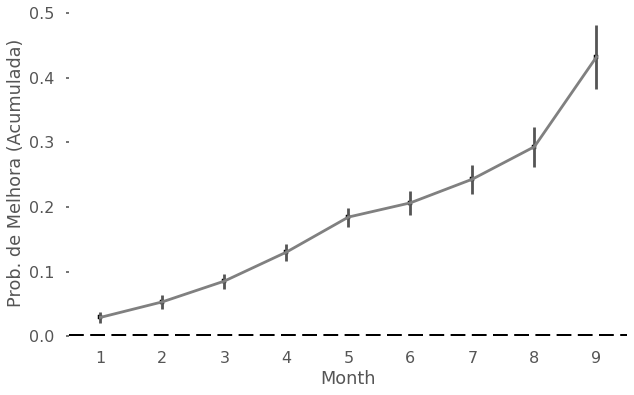

In [11]:
style.use('ggplot')

style.use('seaborn-poster')

fig, ax = plt.subplots(figsize=(10, 6))
coef_df.plot(x='month', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

coef_df.plot(x='month', y='coef', kind='line',
            linestyle='-', ax=ax, color='gray',
             legend=False)

ax.set_ylabel('Prob. de Melhora (Acumulada)')
ax.set_xlabel('Month')


ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=10,
           y=coef_df['coef'], color='black')

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)

ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9'], 
                       rotation=0, fontsize=16)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('white')

plt.show()

***

# 4. Simulated effect - Psychology Effect for Moderates

Let's look at the psychology effect, ie, the treatment effect of going to a psychologist in month *j*.  We estimate the *marginal causal effect* of going to one additional psychology appointment in the Accumulated Probability of improvement, in month $j$ and months $j+1, j+2$ (lag effect). Notice, the effect is constant across the additional appointment, that is, the effect of going to one vs zero is the same as going to two vs one. 

First, We change from *Accumulated Probability* $MelhoraMth$ to *Current Probability*, $MelhoraMth'$, and, for now, we estimate this effect for **Moderate** and then **Disorders**.The model to be estimated is, for each subsample $\{Moderates, Disorders\}$:


$$
MelhoraMth'_{ij} = \sum_{j=3}^{9} \beta_j \times Month_{ij} + \gamma_0 \times PsyAppointQty_{j}  + \gamma_1 \times PsyAppointQty_{j-1} + \gamma_2 \times PsyAppointQty_{j-2} + \alpha_i + \epsilon_{ij}
$$
Notice that we lose the first two months, since we do not have $t-1,t-2$ observations for the first months. Also, one reason to not do everything in the same regression is that, even with relatively large samples in moderates and disorders is that for the last months, the number of observations are greatly reduced, so the estimates have very large errors.
***
Afterwards, we simulate, through *t-tests* of linear combination of the the estimated $\hat{\gamma_0}, \hat{\gamma_1}, \hat{\gamma_2}$ coefficients, the *additional probability* that the following scenario brings for each month:

    - 10x psychology appointments;
    - no  psychology appointments.
    
 and if they are statistically $\neq 0$. For each additional probability that is statiscally significant we add them to the accumulated probability curve we found in section 3. 
 
 Here we made the following overstretches: **One**, that the curves we found in section 3 can be applied to the subpopulations, ie, that they are true causal effects that homogenously affects everyone the same (although ITT). **Two**, that the estimated additional effects are also *true* causal effects, and that they can be added to the ITT without any issues. One positive argument for this approach is that the average number of psicotherapy sessions is very low throughout the months, with median=0, so adding the zero treatment scenario to the accumulative probability is similar to having no treatment at all, instead of adding to a non-zero significant psychotherapy effect
 ***

4.1 Table preparation for The Simulated Treatments

In [12]:
#sorting
sm_df.sort_values(by= ['member_internal_code', 'program_name', 'month_ord_on_program'], inplace = True)

#creating the lags variables
sm_df= sm_df.merge(sm_df.groupby(['member_internal_code', 'program_name'])['psico_qt_consultas'].shift(1).rename('psico_qt_lag1'),
                    how = 'inner', left_index= True, right_index=True)
sm_df.sort_values(by= ['member_internal_code', 'program_name', 'month_ord_on_program'], inplace = True)
sm_df= sm_df.merge(sm_df.groupby(['member_internal_code', 'program_name'])['psico_qt_consultas'].shift(2).rename('psico_qt_lag2'),
                    how = 'inner', left_index= True, right_index=True)
sm_df.sort_values(by= ['member_internal_code', 'program_name', 'month_ord_on_program'], inplace = True)

sm_df = sm_df.merge(sm_df[sm_df['is_alta_mth']==1].groupby(['member_internal_code', 'program_name'])['calendar_date'].min().rename('alta_date').reset_index(),
   how = 'left', left_on=['member_internal_code', 'program_name'], right_on = ['member_internal_code', 'program_name'])

#Adjusting for current, not accumulated, probability
sm_df = sm_df[(sm_df['alta_date'].isna() == True)|(sm_df['calendar_date']<= sm_df['alta_date'])]

#creating interactive variables
sm_df['psico_qt_mth_3'] = sm_df['psico_qt_consultas']* sm_df['is_mth_3']
sm_df['psico_qt_mth_4'] = sm_df['psico_qt_consultas']* sm_df['is_mth_4']
sm_df['psico_qt_mth_5'] = sm_df['psico_qt_consultas']* sm_df['is_mth_5']
sm_df['psico_qt_mth_6'] = sm_df['psico_qt_consultas']* sm_df['is_mth_6']
sm_df['psico_qt_mth_7'] = sm_df['psico_qt_consultas']* sm_df['is_mth_7']
sm_df['psico_qt_mth_8'] = sm_df['psico_qt_consultas']* sm_df['is_mth_8']
sm_df['psico_qt_mth_9'] = sm_df['psico_qt_consultas']* sm_df['is_mth_9']

sm_df['psico_qt_lag1_mth_3'] = sm_df['psico_qt_lag1']* sm_df['is_mth_3']
sm_df['psico_qt_lag1_mth_4'] = sm_df['psico_qt_lag1']* sm_df['is_mth_4']
sm_df['psico_qt_lag1_mth_5'] = sm_df['psico_qt_lag1']* sm_df['is_mth_5']
sm_df['psico_qt_lag1_mth_6'] = sm_df['psico_qt_lag1']* sm_df['is_mth_6']
sm_df['psico_qt_lag1_mth_7'] = sm_df['psico_qt_lag1']* sm_df['is_mth_7']
sm_df['psico_qt_lag1_mth_8'] = sm_df['psico_qt_lag1']* sm_df['is_mth_8']
sm_df['psico_qt_lag1_mth_9'] = sm_df['psico_qt_lag1']* sm_df['is_mth_9']

sm_df['psico_qt_lag2_mth_3'] = sm_df['psico_qt_lag2']* sm_df['is_mth_3']
sm_df['psico_qt_lag2_mth_4'] = sm_df['psico_qt_lag2']* sm_df['is_mth_4']
sm_df['psico_qt_lag2_mth_5'] = sm_df['psico_qt_lag2']* sm_df['is_mth_5']
sm_df['psico_qt_lag2_mth_6'] = sm_df['psico_qt_lag2']* sm_df['is_mth_6']
sm_df['psico_qt_lag2_mth_7'] = sm_df['psico_qt_lag2']* sm_df['is_mth_7']
sm_df['psico_qt_lag2_mth_8'] = sm_df['psico_qt_lag2']* sm_df['is_mth_8']
sm_df['psico_qt_lag2_mth_9'] = sm_df['psico_qt_lag2']* sm_df['is_mth_9']

# new dataframes for each program
sm_df_leve = sm_df[sm_df['program_sev']=='LEVE']
sm_df_mod = sm_df[(sm_df['program_sev']=='MODERADO') & (sm_df['month_ord_on_program']>=3)]
sm_df_grave = sm_df[sm_df['program_sev']=='GRAVE']
sm_df_transt = sm_df[(sm_df['program_sev']=='TRANSTORNO') & (sm_df['month_ord_on_program']>=3)]

#### 4.2 Psychology Effect: Moderates

In [13]:
ols_dd_mod = smf.ols(('is_alta_mth ~ psico_qt_consultas + psico_qt_lag1 + psico_qt_lag2 + \
                       is_mth_3 + is_mth_4 + is_mth_5 + is_mth_6 + is_mth_7 + \
                       is_mth_8 + is_mth_9 + member_internal_code',
                data=sm_df_mod).fit()
err_series_mod = ols_dd_mod.params - ols_dd_mod.conf_int()[0]

In [14]:
coef_df_mod = pd.DataFrame({'coef': ols_dd_mod.params[553:560].values,
                        'err': err_series_mod[553:560].values,
                        'month': ['3', '4', '5', '6', '7', '8', '9']
                       })
coef_df_mod

,coef,err,month
0,-0.067051,0.037139,3
1,-0.029980,0.037558,4
2,0.012244,0.038459,5
3,0.033675,0.040784,6
4,0.059026,0.044087,7
5,0.077342,0.053875,8
6,0.169749,0.077512,9


### 4.3 Simulating treatments:

4.3.1 Linear combination of coefficients and values in the dependent variables for each treatment

In [15]:
###1-1 for 9 mths

coef_df_mod['final_coef'] = coef_df_mod['coef']
coef_df_mod['final_err'] = coef_df_mod['err']

#3th mth
hypotheses = 'is_mth_3 + 2*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='3','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='3','final_err'] = t_test.effect - t_test.conf_int()[0][0]


#4th mth
hypotheses = 'is_mth_4 + 2*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='4','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='4','final_err'] = t_test.effect - t_test.conf_int()[0][0]


#5th mth
hypotheses = 'is_mth_5 + 2*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='5','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='5','final_err'] = t_test.effect - t_test.conf_int()[0][0]

#6th mth
hypotheses = 'is_mth_6 + 0*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='6','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='6','final_err'] = t_test.effect - t_test.conf_int()[0][0]

#7th mth
hypotheses = 'is_mth_7 + 0*psico_qt_consultas + 0*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='7','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='7','final_err'] = t_test.effect - t_test.conf_int()[0][0]

#8th mth
hypotheses = 'is_mth_8 + 0*psico_qt_consultas + 0*psico_qt_lag1 +  0*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='8','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='8','final_err'] = t_test.effect - t_test.conf_int()[0][0]

#9th mth
hypotheses = 'is_mth_9 + 0*psico_qt_consultas + 0*psico_qt_lag1 +  0*psico_qt_lag2'
t_test = ols_dd_mod.t_test(hypotheses)

coef_df_mod.loc[coef_df_mod['month']=='9','final_coef'] = t_test.effect
coef_df_mod.loc[coef_df_mod['month']=='9','final_err'] = t_test.effect - t_test.conf_int()[0][0]

4.3.2 Estimated additional effects

In [16]:
coef_df_mod = coef_df_mod.rename(columns = {'coef': 'Sem tratamento', 'final_coef': 'Adicional de prob. dado por tratamento simulado'})
coef_df_mod

,Sem tratamento,err,month,Adicional de prob. dado por tratamento simulado,final_err
0,-0.067051,0.037139,3,0.120542,0.091533
1,-0.029980,0.037558,4,0.157614,0.085527
2,0.012244,0.038459,5,0.199838,0.085338
3,0.033675,0.040784,6,0.144508,0.071859
4,0.059026,0.044087,7,0.148997,0.061619
5,0.077342,0.053875,8,0.077342,0.053875
6,0.169749,0.077512,9,0.169749,0.077512


4.3.3 Add the $\neq 0$ estimated additional probabilities to the accumulated probabilities

In [17]:
## KEEPING most of estimated acc. probability as it is, since all are differt from zero. all of the coefficients to the acc. probability estimates, since all 
coef_df['mod_coef_SEM_treat_sim'] = coef_df['coef']
coef_df['mod_coef_SEM_treat_sim'][2:9] = coef_df_mod['Sem tratamento'].values + coef_df['coef'][2:9].values

coef_df['mod_coef_COM_treat_sim'] = coef_df['coef']
coef_df['mod_coef_COM_treat_sim'][2:9] = coef_df_mod['Adicional de prob. dado por tratamento simulado'].values + coef_df['coef'][2:9].values

coef_df = coef_df.rename(columns = {'coef': 'Baseline (Todos)',
                                           'mod_coef_SEM_treat_sim': 'Moderado SEM psicoterapia',
                                           'mod_coef_COM_treat_sim': 'Moderado COM psicoterapia (10x)'} 
                        )

### 4.4 Accumulated Probability: Moderate case

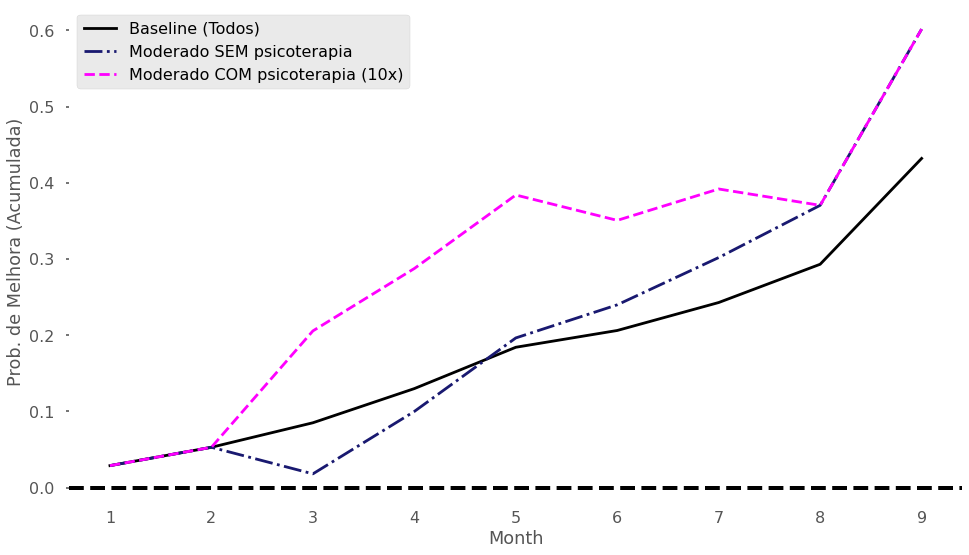

In [18]:
style.use('seaborn-poster')

fig, ax = plt.subplots(figsize=(16, 9))

coef_df.plot(x='month', y='Baseline (Todos)', kind='line',
            linestyle='-', ax=ax, color='black',
             legend=True)

coef_df.plot(x='month', y='Moderado SEM psicoterapia', kind='line',
            linestyle='-.', ax=ax, color='midnightblue',
             legend=True)

coef_df.plot(x='month', y='Moderado COM psicoterapia (10x)', kind='line',
            linestyle='--', ax=ax, color='magenta',
             legend=True)

ax.set_ylabel('Prob. de Melhora (Acumulada)')
ax.set_xlabel('Month')

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)

ax.xaxis.set_ticks_position('none')


ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('white')

plt.show()

***
# 5. Simulated effect - Psychology Effect for Disorders

#### 5.1 Psychology Effect: Disorders

In [19]:
ols_dd_transt = smf.ols(('is_alta_mth ~ psico_qt_consultas + psico_qt_lag1 + \
                          psico_qt_lag2 +  is_mth_3 + is_mth_4 + is_mth_5 + \
                          is_mth_6 + is_mth_7 + is_mth_8 + is_mth_9 + member_internal_code',
                        data=sm_df_transt).fit()
                        
err_series_transt = ols_dd_transt.params - ols_dd_transt.conf_int()[0]

In [20]:
coef_df_transt = pd.DataFrame({'coef': ols_dd_transt.params[980:987].values,
                        'err': err_series_transt[980:987].values,
                        'month': ['3', '4', '5', '6', '7', '8', '9']
                       })
coef_df_transt

,coef,err,month
0,-0.072845,0.041452,3
1,-0.034203,0.041267,4
2,0.005424,0.042123,5
3,0.028769,0.044288,6
4,0.029288,0.047501,7
5,0.049802,0.054555,8
6,0.047290,0.082425,9


### 5.2 Simulating treatments:

5.2.1 Linear combination of coefficients and values in the dependent variables for each treatment

In [21]:
###1-1 for 9 mths

coef_df_transt['final_coef'] = coef_df_transt['coef']
coef_df_transt['final_err'] = coef_df_transt['err']

#3th mth
hypotheses = 'is_mth_3 + 2*psico_qt_consultas + 3*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='3','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='3','final_err'] = t_test.effect - t_test.conf_int()[0][0]


#4th mth
hypotheses = 'is_mth_4 + 2*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='4','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='4','final_err'] = t_test.effect - t_test.conf_int()[0][0]


#5th mth
hypotheses = 'is_mth_5 + 2*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='5','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='5','final_err'] = t_test.effect - t_test.conf_int()[0][0]


#6th mth
hypotheses = 'is_mth_6 + 0*psico_qt_consultas + 2*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='6','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='6','final_err'] = t_test.effect - t_test.conf_int()[0][0]


#7th mth
hypotheses = 'is_mth_7 + 0*psico_qt_consultas + 0*psico_qt_lag1 +  2*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='7','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='7','final_err'] = t_test.effect - t_test.conf_int()[0][0]

#8th mth
hypotheses = 'is_mth_8 + 0*psico_qt_consultas + 0*psico_qt_lag1 +  0*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='8','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='8','final_err'] = t_test.effect - t_test.conf_int()[0][0]

#9th mth
hypotheses = 'is_mth_9 + 0*psico_qt_consultas + 0*psico_qt_lag1 +  0*psico_qt_lag2'
t_test = ols_dd_transt.t_test(hypotheses)

coef_df_transt.loc[coef_df_transt['month']=='9','final_coef'] = t_test.effect
coef_df_transt.loc[coef_df_transt['month']=='9','final_err'] = t_test.effect - t_test.conf_int()[0][0]


5.2.2 Estimated additional effects

In [22]:
coef_df_transt = coef_df_transt.rename(columns = {'coef': 'Sem tratamento', 'final_coef': 'Adicional de prob. dado por tratamento simulado'})
coef_df_transt

,Sem tratamento,err,month,Adicional de prob. dado por tratamento simulado,final_err
0,-0.072845,0.041452,3,0.039797,0.090334
1,-0.034203,0.041267,4,0.072256,0.077698
2,0.005424,0.042123,5,0.111883,0.077489
3,0.028769,0.044288,6,0.118265,0.067948
4,0.029288,0.047501,7,0.106418,0.059955
5,0.049802,0.054555,8,0.049802,0.054555
6,0.047290,0.082425,9,0.047290,0.082425


5.2.3 Add the $\neq 0$ estimated additional probabilities to the accumulated probabilities

In [23]:
coef_df['transt_coef_SEM_treat_sim'] = coef_df['Baseline (Todos)']
coef_df['transt_coef_SEM_treat_sim'][2] = coef_df_transt['Sem tratamento'][2] + coef_df['Baseline (Todos)'][2]

coef_df['transt_coef_COM_treat_sim'] = coef_df['Baseline (Todos)']
coef_df['transt_coef_COM_treat_sim'][4:7] = coef_df_transt['Adicional de prob. dado por tratamento simulado'][2:5].values + coef_df['Baseline (Todos)'][4:7].values

In [24]:
coef_df = coef_df.rename(columns = {'transt_coef_SEM_treat_sim': 'Transtornos SEM psicoterapia',
                                    'transt_coef_COM_treat_sim': 'Transtornos COM psicoterapia (10x)'})

### 5.3 Accumulated Probability: Disorder case

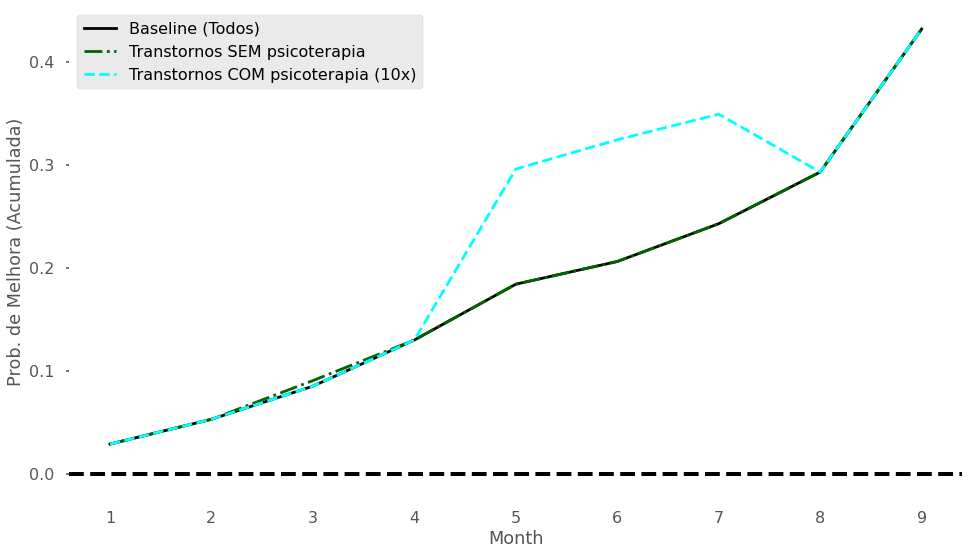

In [25]:
style.use('seaborn-poster')

fig, ax = plt.subplots(figsize=(16, 9))

coef_df.plot(x='month', y='Baseline (Todos)', kind='line',
            linestyle='-', ax=ax, color='black',
             legend=True)

coef_df.plot(x='month', y='Transtornos SEM psicoterapia', kind='line',
            linestyle='-.', ax=ax, color='darkgreen',
             legend=True)

coef_df.plot(x='month', y='Transtornos COM psicoterapia (10x)', kind='line',
            linestyle='--', ax=ax, color='cyan',
             legend=True)


ax.set_ylabel('Prob. de Melhora (Acumulada)')
ax.set_xlabel('Month')

ax.axhline(y=0, linestyle='--', color='black', linewidth=4)

ax.xaxis.set_ticks_position('none')


ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('white')

plt.show()

***
# 6. Cost Analysis

### How much are spending, on average for each month and treatment, on psychologists + psychiatrists, for the improvements?
 - 1. Let's get the total n. of months and the total care cost for each member
 - 2. Then, we average the total care cost for the number of months.
 - 3. To get an *heuristic* view on how much we would spent for every member to be improved, we weight the avg monthly cost (of the *IMPROVED* members) by the percentage of members that got better

In [26]:
#Create a new df 
sm_df_care_cost = sm_df.groupby(['member_internal_code', 'program_sev'])['total_mths','mental_care_cost', 'is_alta_mth'].mean().reset_index()
#take the "zero" treatment out
sm_df_care_cost=sm_df_care_cost[(sm_df_care_cost['program_sev']!= 'ZERO')]
#adjust so we differentiate improvements
sm_df_care_cost['is_alta_mth'] = np.where(sm_df_care_cost['is_alta_mth']>0, 1, 0)
#get the monthly cost.
sm_df_care_cost['month_cost'] = sm_df_care_cost['mental_care_cost']/sm_df_care_cost['total_mths']
#get the total care_cost of mental therapy, ie, psychologist + ps
sm_care_cost = sm_df_care_cost.groupby(['program_sev'])[['month_cost', 'is_alta_mth']].mean().reset_index()
sm_care_cost['monthly_care_cost_for_discharged'] = (sm_care_cost['month_cost']/sm_care_cost['is_alta_mth'])
sm_care_cost['avg_monthly_care_cost_for_improvement_on_all'] = (sm_care_cost['month_cost']/sm_care_cost['is_alta_mth'])/sm_care_cost['is_alta_mth']
sm_care_cost['avg_total_care_cost_for_improvement_on_all'] = sm_care_cost['avg_monthly_care_cost_for_improvement_on_all']*9

#
sm_care_cost

,program_sev,month_cost,is_alta_mth,monthly_care_cost_for_discharged,avg_monthly_care_cost_for_improvement_on_all,avg_total_care_cost_for_improvement_on_all
0,GRAVE,72.390775,0.156379,462.919956,2960.251300,26642.261703
1,LEVE,15.964577,0.080537,198.226837,2461.316559,22151.849035
2,MODERADO,50.880093,0.143019,355.756842,2487.474426,22387.269835
3,TRANSTORNO,61.228505,0.193711,316.082217,1631.723132,14685.508188


## 6.1 Cost Effective Analysis - Using DALYs
- We can analyze the cost effectiveness of the *disorders* protocol;
- WHO has weights for the disorders CIDs, so we can analytically calculate the recovered DALYs for all members in the disorder protocol;
- Using the disorders as the `upper` bound on recovered DALYs, we can calculate the `lower` bound for the other protocols, if we consider than as at **most** severe as the milder disorder condition,
- we calculate the lower bound for the moderate case, using the moderate `total_care_cost_for_improvement`

In [27]:
sm_care_cost[sm_care_cost['program_sev']=='TRANSTORNO']['avg_total_care_cost_for_improvement_on_all']*1590

3    2.334996e+07
Name: avg_total_care_cost_for_improvement_on_all, dtype: float64

**NOTE**: *rounding the values inside the multiplication gives us the R$ 22.968Mi in the slides*

6.1.1 The total cost for improvement on all members under the *disorders* protocol:

The upper and lower bound of the Recovered DALYs for the disorders, based on WHO-2019 calculation for the GAD CIDS (F41) are:

Lower:

$45 \times 0.033 \times 1590 \cong 2385$

Upper:

$45 \times 0.581 \times 1590 \cong ~41570$

*45 is more or less the survival life expectancy of the members - they are on average ~30 years old*. Dividing the lower-upper of the recovered DALYs by the ~cost gives us:

Disorder DALY bounds: $ \left[ R\$ 550,  R\$ 9.630 \right] $ 


Being *heuristic* again, if we multiply the upper bound by the ratio of monthly cost for the treated (moderate) related to monthly cost for the treated (disorder) ($\cong 1.12$), we get the *lower* bound for the Moderate case, which gives us:

Moderate DALY bounds: $ \left[ R\$ 10.648,  \infty \right) $ 


***